# Estimating the `"delta selection-departure"` 

In [314]:
import os
import logging
from tqdm import tqdm_notebook as tqdm
import numpy as np

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split , ShuffleSplit, KFold
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [9]:
from parse import FirePandas, TIME_NORMALISER, IDX_COLNAME, train_data_path, val_data_path, test_data_path, categories_path
from challenge_utils import save_submission


## Load Datasets :

In [10]:
x_features = [
    'alert reason category',
#     'alert reason',
    'intervention on public roads',
    'floor',
    'location of the event',
#     'longitude intervention', 'latitude intervention',
    'emergency vehicle type',
#     'rescue center',
#     'selection time',
#     'selection time',
    'status preceding selection',
    'delta status preceding selection-selection',
    'departed from its rescue center',
#     'longitude before departure',
#     'latitude before departure',
#     'delta position gps previous departure-departure',
#     'GPS tracks departure-presentation',
#     'GPS tracks datetime departure-presentation',
    'GPS tracks datetime departure-presentation selection-first',
#     'GPS tracks datetime departure-presentation selection-last',
#     'GPS tracks datetime departure-presentation first-last',
#     'OSRM estimated distance', 'OSRM estimated duration',
    'selection time month', 
#     'selection time day', 
    'selection time hour', 
#     'selection time minute',
    'selection time day of week',
    'selection time is holiday',
#     'OSRM estimated distance from last observed GPS position',
#     'OSRM estimated duration from last observed GPS position',
#     'time elapsed between selection and last observed GPS position',
#     'updated OSRM estimated duration'
]

y_features = [
    'delta selection-departure',
#     'delta departure-presentation',
 #   'delta selection-presentation'
]


In [301]:
x_features = [
#     'alert reason category',
#     'alert reason',
#     'intervention on public roads',
#     'floor',
#     'location of the event',
#     'longitude intervention', 'latitude intervention',
    'emergency vehicle type',
    'rescue center',
#     'selection time',
    'status preceding selection',
    'delta status preceding selection-selection',
    'departed from its rescue center',
#     'longitude before departure',
#     'latitude before departure',
#     'delta position gps previous departure-departure',
#     'GPS tracks departure-presentation',
#     'GPS tracks datetime departure-presentation',
    'GPS tracks datetime departure-presentation selection-first',
#     'GPS tracks datetime departure-presentation selection-last',
#     'GPS tracks datetime departure-presentation first-last',
#     'OSRM estimated distance', 'OSRM estimated duration',
#     'selection time month', 
#     'selection time day', 
    'selection time hour', 
#     'selection time minute',
#     'selection time day of week',
#     'selection time is holiday',
#     'OSRM estimated distance from last observed GPS position',
#     'OSRM estimated duration from last observed GPS position',
    'time elapsed between selection and last observed GPS position',
#     'updated OSRM estimated duration'
]

y_features = [
    'delta selection-departure',
#     'delta departure-presentation',
 #   'delta selection-presentation'
]


In [134]:
train0_dmatrix, train1_dmatrix, test_dmatrix = None, None, None

In [135]:
X_train, y_train, X_test = None, None, None

In [307]:
train_data = FirePandas.load_pickle(train_data_path, categories_path=categories_path)
val_data   = FirePandas.load_pickle(  val_data_path, categories_path=categories_path)
test_data  = FirePandas.load_pickle( test_data_path, categories_path=categories_path)


INFO:root:Loading categories...
INFO:root:Loading categories...
INFO:root:Loading categories...


In [308]:
### Filter outliers :

threshold = 1
mask = train_data.df['delta selection-departure'] < threshold
print("NOT removing {0:.4}%".format(sum(~mask)*100/len(mask)))
# mask
# train_data.df = train_data.df[mask]


NOT removing 0.01759%


In [309]:
train_dmatrix = train_data.get_DMatrix(x_features, y_features=y_features)
val_dmatrix   =   val_data.get_DMatrix(x_features, y_features=y_features)
test_dmatrix  =  test_data.get_DMatrix(x_features)
print('train: {}, val: {}, test: {}'.format(train_dmatrix.num_row(), val_dmatrix.num_row(), test_dmatrix.num_row()))
print('num_features = {}\n'.format(train_dmatrix.num_col()))
_ = [print(x) for x in zip(train_dmatrix.feature_names, train_dmatrix.feature_types)]

INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...


train: 153535, val: 65802, test: 108033
num_features = 179

('emergency vehicle type AR', 'int')
('emergency vehicle type BEAA BSPP', 'int')
('emergency vehicle type CA', 'int')
('emergency vehicle type CCR BSPP', 'int')
('emergency vehicle type CD BSPP', 'int')
('emergency vehicle type CESD', 'int')
('emergency vehicle type CFS', 'int')
('emergency vehicle type CMO APP', 'int')
('emergency vehicle type CRAC', 'int')
('emergency vehicle type CRF', 'int')
('emergency vehicle type CSP', 'int')
('emergency vehicle type DAP', 'int')
('emergency vehicle type DEP', 'int')
('emergency vehicle type EPA BSPP', 'int')
('emergency vehicle type EPAN', 'int')
('emergency vehicle type EPSA', 'int')
('emergency vehicle type ESAV', 'int')
('emergency vehicle type ESAVI', 'int')
('emergency vehicle type FA', 'int')
('emergency vehicle type FFSS', 'int')
('emergency vehicle type FMOGP BSPP', 'int')
('emergency vehicle type FNPC', 'int')
('emergency vehicle type FPT BSPP', 'int')
('emergency vehicle type

In [310]:
_, _, np_y_train = train_data.get_numpy([], y_features)
_, _, np_y_val = val_data.get_numpy([], y_features)

print('mean   : ', r2_score(np_y_val, np.repeat(np.mean(  np_y_train), len(np_y_val))))
print('median : ', r2_score(np_y_val, np.repeat(np.median(np_y_train), len(np_y_val))))

INFO:root:Creating numpy arrays...
INFO:root:Creating numpy arrays...


mean   :  -1.581743041545458e-05
median :  -0.00726060515015825


## clustering vehicule type

[0 5 2 5 2 3 8 5 2 8 3 4 0 5 5 5 8 2 5 8 2 8 5 6 5 4 3 5 3 8 8 2 4 2 4 9 9
 4 1 1 2 2 4 8 2 0 2 2 8 2 9 0 1 3 7 3 1 3 2 5 4 9 0 2 5 3 4 3 2 2 2 3 8 7
 0]


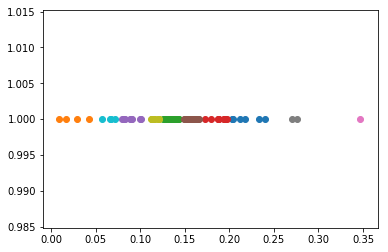

In [244]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

k = 10
# clsf = KMeans(n_clusters=k)

key="emergency vehicle type"
col = train_data.df[[key, 'delta selection-departure',]]
global_mean = col['delta selection-departure'].mean() 
col = col.groupby(key).mean().fillna(global_mean)

cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
new_labels = cluster.fit_predict(col)
print(new_labels)
for i in range(k):
    mask = new_labels==i
    plt.scatter(col[mask], mask[mask] )
    
# plt.xlim([0,1])
plt.show()

---

##  parameter tuning 

from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f 

In [4]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'reg_alpha': 1, # regularisation, enforce sparcity
}

In [13]:
# params['eval_metric'] = "rmse" #"rmse" "mse"  ??? TODO

In [14]:
num_boost_round = 999

## Parameters `max_depth` and `min_child_weight`
`

In [43]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [3, 5, 10, 20, 30]
    for min_child_weight in [1, 3, 5, 8]
]
print(len(gridsearch_params))

20


In [ ]:
%time 

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    %time cv_results = xgb.cv(\
            params, train_dmatrix,\
            num_boost_round=num_boost_round,\
            seed=42, nfold=5, \
            metrics={'rmse'},\
            early_stopping_rounds=5\
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

In [15]:
params['max_depth'] = 10
params['min_child_weight'] = 1


## Parameters `subsample` and `colsample_bytree`

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [.7, .8, .9, 1]
    for colsample in [.7, .8, .9, 1]
]

In [17]:
%time

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    %time cv_results = xgb.cv(\
        params, train_dmatrix,\
        num_boost_round=num_boost_round,\
        seed=42, nfold=5,\
        metrics={'rmse'},\
        early_stopping_rounds=5\
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
CV with subsample=1, colsample=1
CPU times: user 7min 44s, sys: 3.39 s, total: 7min 47s
Wall time: 1min 1s
	MAE 0.033082799999999996 for 35 rounds

CV with subsample=1, colsample=0.9


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


CPU times: user 7min 20s, sys: 3.76 s, total: 7min 24s
Wall time: 59.1 s
	MAE 0.0330992 for 34 rounds

CV with subsample=1, colsample=0.8
CPU times: user 8min 29s, sys: 3.86 s, total: 8min 33s
Wall time: 1min 6s
	MAE 0.0330946 for 44 rounds

CV with subsample=1, colsample=0.7
CPU times: user 7min 12s, sys: 3.51 s, total: 7min 15s
Wall time: 57.1 s
	MAE 0.0330704 for 41 rounds

CV with subsample=0.9, colsample=1
CPU times: user 8min 15s, sys: 3.36 s, total: 8min 18s
Wall time: 1min 5s
	MAE 0.03318460000000001 for 33 rounds

CV with subsample=0.9, colsample=0.9
CPU times: user 7min 43s, sys: 3.37 s, total: 7min 46s
Wall time: 1min 1s
	MAE 0.0331518 for 33 rounds

CV with subsample=0.9, colsample=0.8
CPU times: user 6min 42s, sys: 3.28 s, total: 6min 45s
Wall time: 53.2 s
	MAE 0.0331772 for 31 rounds

CV with subsample=0.9, colsample=0.7
CPU times: user 8min 2s, sys: 3.49 s, total: 8min 6s
Wall time: 1min 3s
	MAE 0.033191399999999996 for 44 rounds

CV with subsample=0.8, colsample=1
CPU t

In [18]:
params['subsample'] = 1
params['colsample_bytree'] = 0.7

## Parameter `ETA`

In [19]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(\
            params, train_dmatrix,\
            num_boost_round=num_boost_round,\
            seed=42, nfold=5, \
            metrics=['rmse'],\
            early_stopping_rounds=10\
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs
CV with eta=0.3
CPU times: user 7min 25s, sys: 3.57 s, total: 7min 28s
Wall time: 59 s
	MAE 0.0330704 for 41 rounds

CV with eta=0.2


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  del sys.path[0]


CPU times: user 12min 23s, sys: 4.48 s, total: 12min 28s
Wall time: 1min 36s
	MAE 0.032943200000000006 for 77 rounds

CV with eta=0.1
CPU times: user 29min 54s, sys: 8.22 s, total: 30min 2s
Wall time: 3min 50s
	MAE 0.032805600000000004 for 204 rounds

CV with eta=0.05
CPU times: user 50min 1s, sys: 13.2 s, total: 50min 14s
Wall time: 6min 25s
	MAE 0.0327418 for 344 rounds

CV with eta=0.01
CPU times: user 2h 25min 17s, sys: 37.8 s, total: 2h 25min 55s
Wall time: 18min 39s
	MAE 0.0328202 for 998 rounds

CV with eta=0.005
CPU times: user 2h 32min 10s, sys: 37.4 s, total: 2h 32min 47s
Wall time: 19min 27s
	MAE 0.0333302 for 998 rounds

Best params: 0.05, MAE: 0.0327418


In [20]:
params['eta'] = 0.2

## Final params and model estimation :

In [283]:
params = {
    # Parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 5,
    'eta': .1,
    'subsample': 1,
    'colsample_bytree': .4,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
#     'eval_metric':'mae',
    'reg_alpha': 1, # regularisation, enforce sparcity
}
num_boost_round = 999

In [303]:
model = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=num_boost_round,
    evals=[(val_dmatrix, "Val")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))


[0]	Val-rmse:0.338083
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.306907
[2]	Val-rmse:0.27912
[3]	Val-rmse:0.254389
[4]	Val-rmse:0.232208
[5]	Val-rmse:0.212662
[6]	Val-rmse:0.195482
[7]	Val-rmse:0.18023
[8]	Val-rmse:0.166799
[9]	Val-rmse:0.155213
[10]	Val-rmse:0.145027
[11]	Val-rmse:0.136114
[12]	Val-rmse:0.128542
[13]	Val-rmse:0.12211
[14]	Val-rmse:0.116662
[15]	Val-rmse:0.111888
[16]	Val-rmse:0.107863
[17]	Val-rmse:0.104585
[18]	Val-rmse:0.101752
[19]	Val-rmse:0.099328
[20]	Val-rmse:0.097384
[21]	Val-rmse:0.095792
[22]	Val-rmse:0.094428
[23]	Val-rmse:0.093285
[24]	Val-rmse:0.092399
[25]	Val-rmse:0.091601
[26]	Val-rmse:0.090939
[27]	Val-rmse:0.090467
[28]	Val-rmse:0.090045
[29]	Val-rmse:0.089676
[30]	Val-rmse:0.089356
[31]	Val-rmse:0.089127
[32]	Val-rmse:0.088943
[33]	Val-rmse:0.088752
[34]	Val-rmse:0.088614
[35]	Val-rmse:0.088519
[36]	Val-rmse:0.088435
[37]	Val-rmse:0.088369
[38]	Val-rmse:0.088272
[39]	Val-rmse:0.088205
[40]	Val-rmse:0.088158
[41]	Val-rmse:

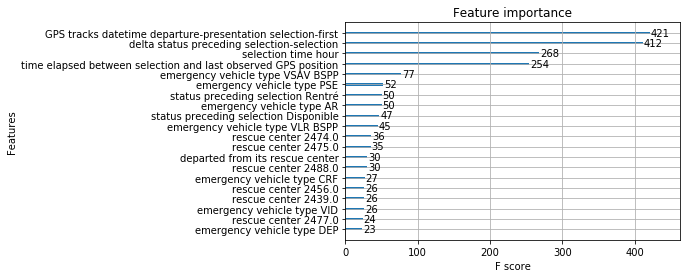

In [304]:
plot_importance(model, max_num_features=20)
plt.show()

In [312]:
full_df = train_data.df.append(val_data.df)


In [322]:
## crossval
rs = KFold(n_splits=5, random_state=12, shuffle=True)
predictions  = []
for train_index, val_index in tqdm(rs.split(full_df)):
    train_data.df = full_df.ix[train_index]
    val_data.df = full_df.ix[val_index]
    train_dmatrix = train_data.get_DMatrix(x_features, y_features=y_features)
    val_dmatrix   =   val_data.get_DMatrix(x_features, y_features=y_features)
    model = xgb.train(
        params,
        train_dmatrix,
        num_boost_round=num_boost_round,
        evals=[(val_dmatrix, "Val")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )

    print("Best RMSE: {:.4f} in {} rounds".format(model.best_score, model.best_iteration+1))
    val_pred = model.predict(val_dmatrix)
    _, _, val_truth = val_data.get_numpy([], y_features=y_features)
    print("r2_score : ",r2_score(val_truth, val_pred))
    
    predictions.append(model.predict(test_dmatrix))
    

    

/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1017 in 76 rounds
r2_score :  0.1005048864456145


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.0546 in 125 rounds
r2_score :  0.2838832986631239


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.0750 in 78 rounds
r2_score :  0.16624144331046753


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.0521 in 41 rounds
r2_score :  0.21062665703650352


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.0569 in 68 rounds
r2_score :  0.23128714861580135


In [325]:
# test_pred = np.median(np.stack(predictions, axis=1), axis=1)
test_pred = np.mean(np.stack(predictions, axis=1), axis=1)


In [305]:
## r2 score :
val_pred = model.predict(val_dmatrix)
_, _, val_truth = val_data.get_numpy([], y_features=y_features)

print(r2_score(val_truth, val_pred))
x_features


INFO:root:Creating numpy arrays...


0.1440567140829001


['emergency vehicle type',
 'rescue center',
 'status preceding selection',
 'delta status preceding selection-selection',
 'departed from its rescue center',
 'GPS tracks datetime departure-presentation selection-first',
 'selection time hour',
 'time elapsed between selection and last observed GPS position']

#### last r2score :
 - without vehicule type : `0.1437` : prediction_xgboost_0_2019-12-24_22-01.pkl
 - with vehicule type : `0.17501` : prediction_xgboost_0_2019-12-24_22-09.pkl
 - day and min (0.1756 with just one of them..) : `0.17800` : prediction_xgboost_0_2019-12-24_22-24.pkl
 - most recent... prediction_xgboost_0_2019-12-30_23-02.pkl `.1442`
 - kfolds : `prediction_xgboost_0_median_2019-12-31_00-00.pkl` and `prediction_xgboost_0_mean_2019-12-31_00-01.pkl`

## Generate prediction :

In [293]:
import pickle as pkl
import time


In [326]:
# test_pred = model.predict(test_dmatrix)
prediction_path = 'prediction_xgboost_0_mean_{}.pkl'.format(time.strftime("%Y-%m-%d_%H-%M"))
with open(prediction_path, 'wb') as f:
    pkl.dump(test_pred, f)
print('prediction saved at {}'.format(prediction_path))

prediction saved at prediction_xgboost_0_mean_2019-12-31_00-01.pkl
